     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 39.7 MB/s eta 0:00:00
Green Space Equity Mapping Analysis
Supporting SDG 15 - Life on Land
Starting Green Space Equity Analysis...
Fetching city boundary for San Francisco, CA, USA...
Successfully retrieved city boundary
Extracting parks data from OpenStreetMap...
Creating sample parks data...
Created 15 sample parks
Creating analysis grid...
Created 866 grid cells
Simulating population data...
Simulating NDVI data...
Calculating park accessibility...
Calculating green space per capita...
Identifying underserved areas...
Performing cluster analysis...

Cluster Analysis Summary:
         population  nearest_park_distance  parks_within_500m  ndvi  \
cluster                                         

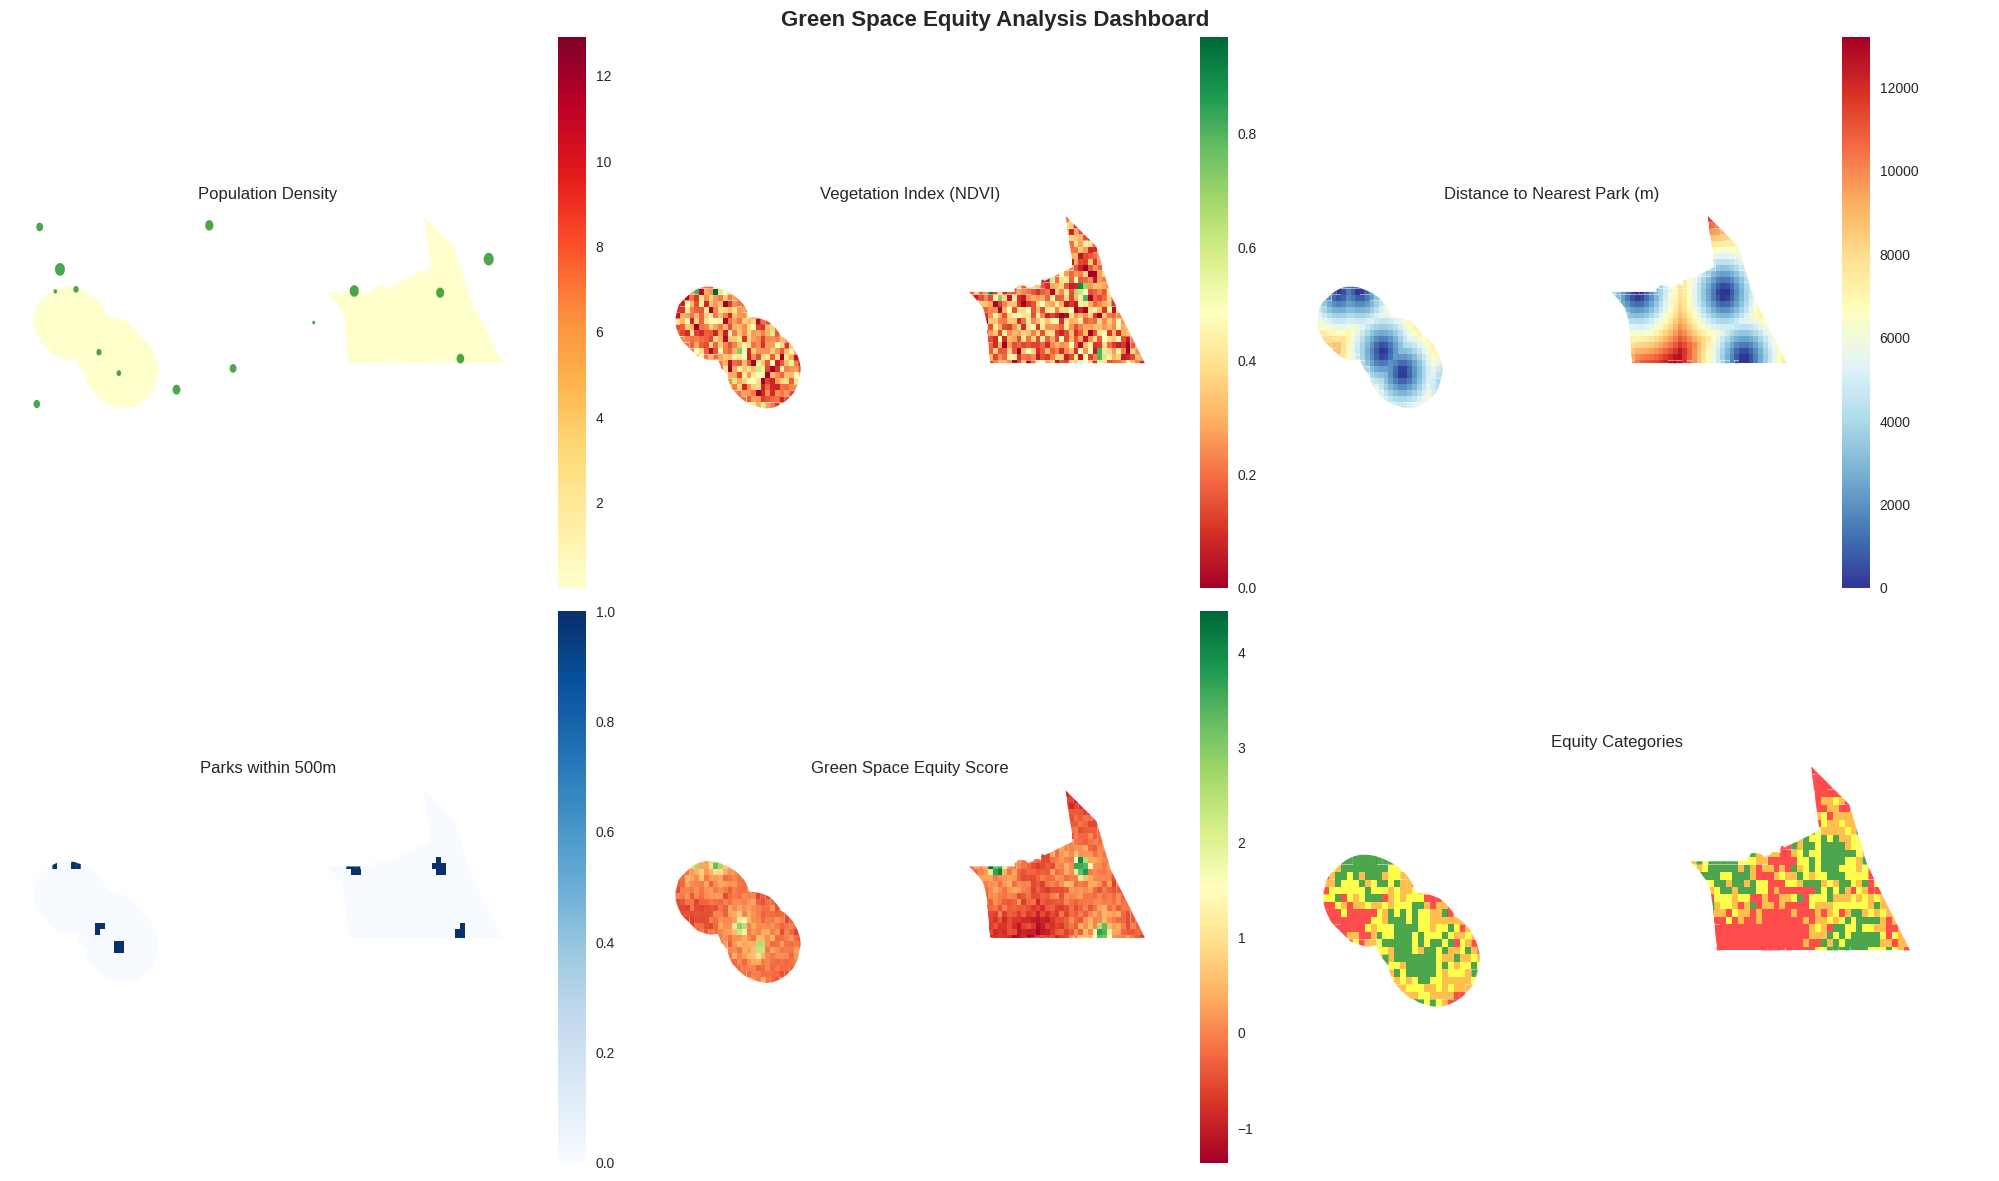


GREEN SPACE EQUITY ANALYSIS SUMMARY
Study Area: San Francisco, CA, USA
Total Population: 215,839
Total Area: 866.00 sq km
Analysis Grid Cells: 866

Parks and Green Spaces:
Total Parks/Green Spaces: 15
Total Park Area: 26.97 sq km
Parks per 1000 people: 0.07

Equity Analysis:
Severely Underserved: 217 cells (25.1%), 54,238 people (25.1%)
Well Served: 217 cells (25.1%), 54,161 people (25.1%)
Adequately Served: 216 cells (24.9%), 53,783 people (24.9%)
Underserved: 216 cells (24.9%), 53,657 people (24.9%)

Key Metrics (Average):
Distance to Nearest Park: 4909m
Parks within 500m: 0.0
NDVI Score: 0.262
Green Space per Capita: 146.22

Most Underserved Areas:
Grid grid_74_7: Score -1.362, Population 255
Grid grid_76_8: Score -1.287, Population 256
Grid grid_71_7: Score -1.199, Population 256
Grid grid_76_9: Score -1.191, Population 243
Grid grid_75_7: Score -1.138, Population 256
Creating interactive map...

Analysis completed successfully!

Displaying interactive map...


In [1]:
# Green Space Equity Mapping Analysis
# Measuring access to parks and green cover to identify underserved areas
# Supporting SDG 15 - Life on Land

# Install required packages
!pip install folium geopandas rasterio rasterstats osmnx networkx requests matplotlib seaborn numpy pandas shapely scikit-learn

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
import folium
from folium import plugins
import rasterio
from rasterio.features import shapes
from rasterio.transform import from_bounds
import requests
from io import BytesIO
import networkx as nx
import osmnx as ox
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class GreenSpaceEquityMapper:
    def __init__(self, city_name="San Francisco, CA, USA", grid_size=1000):
        """
        Initialize the Green Space Equity Mapper

        Parameters:
        city_name (str): Name of the city to analyze
        grid_size (int): Size of analysis grid in meters
        """
        self.city_name = city_name
        self.grid_size = grid_size
        self.city_boundary = None
        self.parks_gdf = None
        self.population_grid = None
        self.ndvi_data = None
        self.analysis_results = None

    def get_city_boundary(self):
        """Get city boundary using OSMnx"""
        print(f"Fetching city boundary for {self.city_name}...")
        try:
            # Get city boundary
            self.city_boundary = ox.geocode_to_gdf(self.city_name)
            print(f"Successfully retrieved city boundary")
            return self.city_boundary
        except Exception as e:
            print(f"Error fetching city boundary: {e}")
            # Fallback to a sample area
            bounds = [-122.5, 37.7, -122.3, 37.8]  # San Francisco sample
            self.city_boundary = gpd.GeoDataFrame(
                [1],
                geometry=[Polygon([
                    (bounds[0], bounds[1]),
                    (bounds[2], bounds[1]),
                    (bounds[2], bounds[3]),
                    (bounds[0], bounds[3])
                ])],
                crs='EPSG:4326'
            )
            return self.city_boundary

    def get_parks_data(self):
        """Extract parks and green spaces from OpenStreetMap"""
        print("Extracting parks data from OpenStreetMap...")
        try:
            # Get the bounding box
            bounds = self.city_boundary.total_bounds

            # Define tags for green spaces
            tags = {
                'leisure': ['park', 'garden', 'recreation_ground', 'nature_reserve'],
                'landuse': ['forest', 'grass', 'recreation_ground'],
                'natural': ['wood', 'grassland']
            }

            # Get parks using OSMnx
            parks_list = []
            for key, values in tags.items():
                for value in values:
                    try:
                        parks = ox.geometries_from_bbox(
                            bounds[3], bounds[1], bounds[2], bounds[0],
                            tags={key: value}
                        )
                        if not parks.empty:
                            parks['park_type'] = f"{key}_{value}"
                            parks_list.append(parks[['geometry', 'park_type']])
                    except:
                        continue

            if parks_list:
                self.parks_gdf = pd.concat(parks_list, ignore_index=True)
                self.parks_gdf = gpd.GeoDataFrame(self.parks_gdf, crs='EPSG:4326')

                # Remove duplicates and invalid geometries
                self.parks_gdf = self.parks_gdf[self.parks_gdf.geometry.is_valid]
                self.parks_gdf = self.parks_gdf.drop_duplicates(subset=['geometry'])

                print(f"Found {len(self.parks_gdf)} green spaces")
            else:
                # Create sample parks data
                print("Creating sample parks data...")
                self.create_sample_parks()

            return self.parks_gdf

        except Exception as e:
            print(f"Error extracting parks data: {e}")
            self.create_sample_parks()
            return self.parks_gdf

    def create_sample_parks(self):
        """Create sample parks data for demonstration"""
        bounds = self.city_boundary.total_bounds
        np.random.seed(42)

        # Generate random park locations
        n_parks = 15
        park_data = []

        for i in range(n_parks):
            # Random location within bounds
            lon = np.random.uniform(bounds[0], bounds[2])
            lat = np.random.uniform(bounds[1], bounds[3])

            # Random park size (radius in degrees)
            radius = np.random.uniform(0.002, 0.01)

            # Create circular park
            center = Point(lon, lat)
            park_geom = center.buffer(radius)

            park_data.append({
                'geometry': park_geom,
                'park_type': np.random.choice(['leisure_park', 'landuse_grass', 'natural_wood']),
                'area_sqm': park_geom.area * 111000 * 111000  # Rough conversion to sq meters
            })

        self.parks_gdf = gpd.GeoDataFrame(park_data, crs='EPSG:4326')
        print(f"Created {len(self.parks_gdf)} sample parks")

    def create_analysis_grid(self):
        """Create analysis grid for the study area"""
        print("Creating analysis grid...")

        # Convert to projected CRS for accurate distance calculations
        bounds = self.city_boundary.total_bounds

        # Create grid
        x_coords = np.arange(bounds[0], bounds[2], self.grid_size / 111000)  # Rough deg conversion
        y_coords = np.arange(bounds[1], bounds[3], self.grid_size / 111000)

        grid_cells = []
        for i, x in enumerate(x_coords[:-1]):
            for j, y in enumerate(y_coords[:-1]):
                cell_id = f"grid_{i}_{j}"
                cell_geom = Polygon([
                    (x, y),
                    (x_coords[i+1], y),
                    (x_coords[i+1], y_coords[j+1]),
                    (x, y_coords[j+1])
                ])

                grid_cells.append({
                    'grid_id': cell_id,
                    'geometry': cell_geom,
                    'x_index': i,
                    'y_index': j
                })

        grid_gdf = gpd.GeoDataFrame(grid_cells, crs='EPSG:4326')

        # Keep only cells that intersect with city boundary
        grid_gdf = gpd.overlay(grid_gdf, self.city_boundary, how='intersection')

        print(f"Created {len(grid_gdf)} grid cells")
        return grid_gdf

    def simulate_population_data(self, grid_gdf):
        """Simulate population density data for each grid cell"""
        print("Simulating population data...")
        np.random.seed(42)

        # Simulate population with some spatial correlation
        populations = []
        for idx, cell in grid_gdf.iterrows():
            # Base population with some randomness
            base_pop = np.random.poisson(500)  # Average 500 people per cell

            # Add spatial correlation (higher population in center)
            center_x = grid_gdf.geometry.centroid.x.mean()
            center_y = grid_gdf.geometry.centroid.y.mean()

            cell_center = cell.geometry.centroid
            distance_from_center = ((cell_center.x - center_x)**2 + (cell_center.y - center_y)**2)**0.5

            # Population decreases with distance from center
            population_multiplier = np.exp(-distance_from_center * 1000)
            final_population = int(base_pop * (0.5 + population_multiplier))

            populations.append(final_population)

        grid_gdf['population'] = populations
        grid_gdf['pop_density'] = grid_gdf['population'] / (grid_gdf.geometry.area * 111000 * 111000)  # per sq km

        return grid_gdf

    def simulate_ndvi_data(self, grid_gdf):
        """Simulate NDVI (vegetation index) data"""
        print("Simulating NDVI data...")
        np.random.seed(42)

        ndvi_values = []
        for idx, cell in grid_gdf.iterrows():
            # Check if cell contains parks
            cell_parks = self.parks_gdf[self.parks_gdf.intersects(cell.geometry)]

            if len(cell_parks) > 0:
                # Higher NDVI near parks
                base_ndvi = np.random.uniform(0.3, 0.8)
            else:
                # Lower NDVI in urban areas
                base_ndvi = np.random.uniform(0.1, 0.4)

            # Add some noise
            ndvi = np.clip(base_ndvi + np.random.normal(0, 0.1), 0, 1)
            ndvi_values.append(ndvi)

        grid_gdf['ndvi'] = ndvi_values
        return grid_gdf

    def calculate_park_accessibility(self, grid_gdf):
        """Calculate park accessibility metrics"""
        print("Calculating park accessibility...")

        accessibility_metrics = []

        for idx, cell in grid_gdf.iterrows():
            cell_center = cell.geometry.centroid

            # Distance to nearest park
            if len(self.parks_gdf) > 0:
                distances = self.parks_gdf.geometry.distance(cell_center)
                nearest_park_distance = distances.min() * 111000  # Convert to meters

                # Number of parks within 500m
                parks_500m = sum(distances <= 500/111000)

                # Total park area within 1km
                nearby_parks = self.parks_gdf[distances <= 1000/111000]
                total_park_area = nearby_parks.geometry.area.sum() * 111000 * 111000  # sq meters
            else:
                nearest_park_distance = 10000  # 10km if no parks
                parks_500m = 0
                total_park_area = 0

            accessibility_metrics.append({
                'nearest_park_distance': nearest_park_distance,
                'parks_within_500m': parks_500m,
                'park_area_within_1km': total_park_area
            })

        accessibility_df = pd.DataFrame(accessibility_metrics)

        # Add to grid
        for col in accessibility_df.columns:
            grid_gdf[col] = accessibility_df[col]

        return grid_gdf

    def calculate_green_space_per_capita(self, grid_gdf):
        """Calculate green space per capita"""
        print("Calculating green space per capita...")

        # Green space per capita (combining parks and NDVI)
        grid_gdf['green_space_score'] = (
            grid_gdf['park_area_within_1km'] / 10000 +  # Normalize park area
            grid_gdf['ndvi'] * 100  # NDVI contribution
        )

        # Per capita calculation
        grid_gdf['green_space_per_capita'] = np.where(
            grid_gdf['population'] > 0,
            grid_gdf['green_space_score'] / grid_gdf['population'] * 1000,  # per 1000 people
            grid_gdf['green_space_score']
        )

        return grid_gdf

    def identify_underserved_areas(self, grid_gdf):
        """Identify underserved areas using multiple criteria"""
        print("Identifying underserved areas...")

        # Create composite equity score
        # Normalize metrics
        scaler = StandardScaler()

        metrics_to_normalize = [
            'nearest_park_distance', 'parks_within_500m', 'park_area_within_1km',
            'ndvi', 'green_space_per_capita', 'pop_density'
        ]

        normalized_data = scaler.fit_transform(grid_gdf[metrics_to_normalize])
        normalized_df = pd.DataFrame(normalized_data, columns=metrics_to_normalize)

        # Calculate equity score (lower is worse)
        equity_score = (
            -normalized_df['nearest_park_distance'] * 0.3 +  # Closer parks = better
            normalized_df['parks_within_500m'] * 0.2 +       # More nearby parks = better
            normalized_df['park_area_within_1km'] * 0.2 +    # More park area = better
            normalized_df['ndvi'] * 0.2 +                    # Higher vegetation = better
            normalized_df['green_space_per_capita'] * 0.1    # More per capita = better
        )

        grid_gdf['equity_score'] = equity_score

        # Classify areas
        equity_percentiles = np.percentile(equity_score, [25, 50, 75])

        def classify_equity(score):
            if score <= equity_percentiles[0]:
                return 'Severely Underserved'
            elif score <= equity_percentiles[1]:
                return 'Underserved'
            elif score <= equity_percentiles[2]:
                return 'Adequately Served'
            else:
                return 'Well Served'

        grid_gdf['equity_category'] = grid_gdf['equity_score'].apply(classify_equity)

        return grid_gdf

    def perform_cluster_analysis(self, grid_gdf):
        """Perform clustering analysis to identify similar areas"""
        print("Performing cluster analysis...")

        # Features for clustering
        cluster_features = [
            'population', 'pop_density', 'nearest_park_distance',
            'parks_within_500m', 'park_area_within_1km', 'ndvi'
        ]

        # Prepare data
        X = grid_gdf[cluster_features].fillna(0)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # K-means clustering
        kmeans = KMeans(n_clusters=5, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)

        grid_gdf['cluster'] = clusters

        # Analyze clusters
        cluster_summary = grid_gdf.groupby('cluster').agg({
            'population': 'mean',
            'nearest_park_distance': 'mean',
            'parks_within_500m': 'mean',
            'ndvi': 'mean',
            'equity_score': 'mean'
        }).round(2)

        print("\nCluster Analysis Summary:")
        print(cluster_summary)

        return grid_gdf, cluster_summary

    def create_visualizations(self, grid_gdf):
        """Create comprehensive visualizations"""
        print("Creating visualizations...")

        # Create figure with subplots
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Green Space Equity Analysis Dashboard', fontsize=16, fontweight='bold')

        # 1. Population Density
        ax1 = axes[0, 0]
        grid_gdf.plot(column='pop_density', ax=ax1, legend=True, cmap='YlOrRd')
        if hasattr(self, 'parks_gdf') and self.parks_gdf is not None:
            self.parks_gdf.plot(ax=ax1, color='green', alpha=0.7)
        ax1.set_title('Population Density')
        ax1.axis('off')

        # 2. NDVI
        ax2 = axes[0, 1]
        grid_gdf.plot(column='ndvi', ax=ax2, legend=True, cmap='RdYlGn')
        ax2.set_title('Vegetation Index (NDVI)')
        ax2.axis('off')

        # 3. Distance to Nearest Park
        ax3 = axes[0, 2]
        grid_gdf.plot(column='nearest_park_distance', ax=ax3, legend=True, cmap='RdYlBu_r')
        ax3.set_title('Distance to Nearest Park (m)')
        ax3.axis('off')

        # 4. Parks within 500m
        ax4 = axes[1, 0]
        grid_gdf.plot(column='parks_within_500m', ax=ax4, legend=True, cmap='Blues')
        ax4.set_title('Parks within 500m')
        ax4.axis('off')

        # 5. Equity Score
        ax5 = axes[1, 1]
        grid_gdf.plot(column='equity_score', ax=ax5, legend=True, cmap='RdYlGn')
        ax5.set_title('Green Space Equity Score')
        ax5.axis('off')

        # 6. Equity Categories
        ax6 = axes[1, 2]

        # Create color map for categories
        category_colors = {
            'Severely Underserved': 'red',
            'Underserved': 'orange',
            'Adequately Served': 'yellow',
            'Well Served': 'green'
        }

        for category, color in category_colors.items():
            subset = grid_gdf[grid_gdf['equity_category'] == category]
            if not subset.empty:
                subset.plot(ax=ax6, color=color, label=category, alpha=0.7)

        ax6.set_title('Equity Categories')
        ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax6.axis('off')

        plt.tight_layout()
        plt.show()

        # Summary statistics
        self.print_summary_statistics(grid_gdf)

        return fig

    def create_interactive_map(self, grid_gdf):
        """Create interactive folium map"""
        print("Creating interactive map...")

        # Calculate center point
        bounds = grid_gdf.total_bounds
        center_lat = (bounds[1] + bounds[3]) / 2
        center_lon = (bounds[0] + bounds[2]) / 2

        # Create base map
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=12,
            tiles='OpenStreetMap'
        )

        # Add equity categories layer
        folium.Choropleth(
            geo_data=grid_gdf.to_json(),
            data=grid_gdf,
            columns=['grid_id', 'equity_score'],
            key_on='feature.properties.grid_id',
            fill_color='RdYlGn',
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name='Green Space Equity Score'
        ).add_to(m)

        # Add parks
        if hasattr(self, 'parks_gdf') and self.parks_gdf is not None:
            for idx, park in self.parks_gdf.iterrows():
                if park.geometry.geom_type == 'Polygon':
                    folium.GeoJson(
                        park.geometry,
                        style_function=lambda x: {
                            'fillColor': 'green',
                            'color': 'darkgreen',
                            'weight': 2,
                            'fillOpacity': 0.7
                        },
                        popup=f"Park Type: {park.get('park_type', 'Unknown')}"
                    ).add_to(m)

        # Add layer control
        folium.LayerControl().add_to(m)

        return m

    def print_summary_statistics(self, grid_gdf):
        """Print comprehensive summary statistics"""
        print("\n" + "="*60)
        print("GREEN SPACE EQUITY ANALYSIS SUMMARY")
        print("="*60)

        total_population = grid_gdf['population'].sum()
        total_area = len(grid_gdf) * (self.grid_size/1000)**2  # sq km

        print(f"Study Area: {self.city_name}")
        print(f"Total Population: {total_population:,}")
        print(f"Total Area: {total_area:.2f} sq km")
        print(f"Analysis Grid Cells: {len(grid_gdf)}")

        print(f"\nParks and Green Spaces:")
        if hasattr(self, 'parks_gdf') and self.parks_gdf is not None:
            print(f"Total Parks/Green Spaces: {len(self.parks_gdf)}")
            total_park_area = self.parks_gdf.geometry.area.sum() * 111000 * 111000 / 1000000  # sq km
            print(f"Total Park Area: {total_park_area:.2f} sq km")
            print(f"Parks per 1000 people: {len(self.parks_gdf) / (total_population/1000):.2f}")

        print(f"\nEquity Analysis:")
        equity_counts = grid_gdf['equity_category'].value_counts()
        for category, count in equity_counts.items():
            percentage = (count / len(grid_gdf)) * 100
            pop_in_category = grid_gdf[grid_gdf['equity_category'] == category]['population'].sum()
            pop_percentage = (pop_in_category / total_population) * 100
            print(f"{category}: {count} cells ({percentage:.1f}%), {pop_in_category:,} people ({pop_percentage:.1f}%)")

        print(f"\nKey Metrics (Average):")
        print(f"Distance to Nearest Park: {grid_gdf['nearest_park_distance'].mean():.0f}m")
        print(f"Parks within 500m: {grid_gdf['parks_within_500m'].mean():.1f}")
        print(f"NDVI Score: {grid_gdf['ndvi'].mean():.3f}")
        print(f"Green Space per Capita: {grid_gdf['green_space_per_capita'].mean():.2f}")

        # Identify most underserved areas
        most_underserved = grid_gdf.nsmallest(5, 'equity_score')[['grid_id', 'equity_score', 'population']]
        print(f"\nMost Underserved Areas:")
        for idx, row in most_underserved.iterrows():
            print(f"Grid {row['grid_id']}: Score {row['equity_score']:.3f}, Population {row['population']}")

        print("="*60)

    def run_complete_analysis(self):
        """Run the complete green space equity analysis"""
        print("Starting Green Space Equity Analysis...")
        print("="*50)

        # Step 1: Get city boundary
        self.get_city_boundary()

        # Step 2: Get parks data
        self.get_parks_data()

        # Step 3: Create analysis grid
        grid_gdf = self.create_analysis_grid()

        # Step 4: Add population data
        grid_gdf = self.simulate_population_data(grid_gdf)

        # Step 5: Add NDVI data
        grid_gdf = self.simulate_ndvi_data(grid_gdf)

        # Step 6: Calculate accessibility metrics
        grid_gdf = self.calculate_park_accessibility(grid_gdf)

        # Step 7: Calculate green space per capita
        grid_gdf = self.calculate_green_space_per_capita(grid_gdf)

        # Step 8: Identify underserved areas
        grid_gdf = self.identify_underserved_areas(grid_gdf)

        # Step 9: Perform cluster analysis
        grid_gdf, cluster_summary = self.perform_cluster_analysis(grid_gdf)

        # Step 10: Create visualizations
        self.create_visualizations(grid_gdf)

        # Step 11: Create interactive map
        interactive_map = self.create_interactive_map(grid_gdf)

        # Store results
        self.analysis_results = grid_gdf

        print("\nAnalysis completed successfully!")
        return grid_gdf, interactive_map

    def export_results(self, filename_prefix="green_space_equity"):
        """Export results to various formats"""
        if self.analysis_results is not None:
            # Export to GeoJSON
            self.analysis_results.to_file(f"{filename_prefix}_results.geojson", driver="GeoJSON")

            # Export to CSV (without geometry)
            results_df = self.analysis_results.drop('geometry', axis=1)
            results_df.to_csv(f"{filename_prefix}_results.csv", index=False)

            print(f"Results exported to {filename_prefix}_results.geojson and {filename_prefix}_results.csv")
        else:
            print("No results to export. Please run the analysis first.")

# Example usage and demonstration
def main():
    print("Green Space Equity Mapping Analysis")
    print("Supporting SDG 15 - Life on Land")
    print("="*50)

    # Initialize the mapper
    mapper = GreenSpaceEquityMapper(
        city_name="San Francisco, CA, USA",  # Change this to your city
        grid_size=1000  # 1km grid cells
    )

    # Run complete analysis
    results, interactive_map = mapper.run_complete_analysis()

    # Display the interactive map
    print("\nDisplaying interactive map...")
    return interactive_map

# Run the analysis
if __name__ == "__main__":
    interactive_map = main()
    # To display the map in Colab, use:
    # interactive_map